# Лабораторна робота №1: Зменшення розмірності даних (PCA + MNIST)

**Мета:** Ознайомитися з основами зменшення розмірності даних на прикладі зображень рукописних цифр із набору MNIST. Навчитись виконувати метод головних компонент (PCA), інтерпретувати результати, оцінювати втрату інформації після проєкції та реконструкції зображень.

**Бібліотеки:** numpy, pandas, matplotlib, scikit-learn (PCA)

---

## 1. Завантаження та підготовка даних

In [1]:
# Імпорт бібліотеки NumPy для роботи з масивами та математичними операціями
import numpy as np

# Імпорт бібліотеки Pandas для роботи з табличними даними
import pandas as pd

# Імпорт модуля matplotlib.pyplot для побудови графіків та візуалізацій
import matplotlib.pyplot as plt

# Імпорт функції fetch_openml для завантаження датасетів з репозиторію OpenML
from sklearn.datasets import fetch_openml

# Імпорт класу PCA (Principal Component Analysis) для зменшення розмірності
from sklearn.decomposition import PCA

# Завантаження датасету MNIST (рукописні цифри 0-9)
# mnist_784 — 70000 зображень 28x28 пікселів, розгорнутих у вектори довжиною 784
# return_X_y=True повертає окремо матрицю ознак X та вектор міток y
# as_frame=False повертає дані як numpy-масиви (а не pandas DataFrame)
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

# Перетворення міток з рядків ('0','1',...,'9') у цілі числа (0,1,...,9)
y_int = y.astype(int)

# Вивід розмірності матриці X: (кількість зображень, кількість пікселів)
print(f"Розмірність матриці X: {X.shape}")

# Вивід кількості різних цифр у датасеті
print(f"Кількість унікальних міток: {len(np.unique(y_int))}")

# Вивід самих міток (від 0 до 9)
print(f"Унікальні мітки: {np.unique(y_int)}")

Розмірність матриці X: (70000, 784)
Кількість унікальних міток: 10
Унікальні мітки: [0 1 2 3 4 5 6 7 8 9]


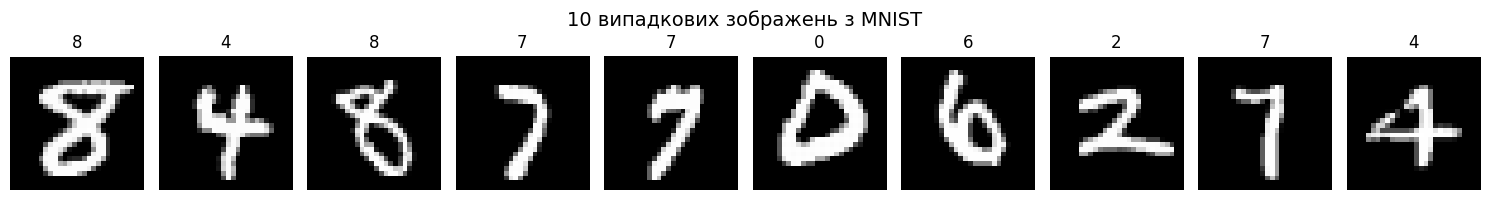

In [2]:
# --- Візуалізація 10 випадкових зображень цифр ---

# Встановлюємо seed для відтворюваності (щоб кожен запуск давав ті самі "випадкові" індекси)
np.random.seed(42)

# Обираємо 10 випадкових індексів із діапазону [0, 70000), без повторень
random_indices = np.random.choice(len(X), size=10, replace=False)

# Створюємо фігуру з 10 підграфіками в один рядок, розмір 15x2 дюймів
fig, axes = plt.subplots(1, 10, figsize=(15, 2))

# Цикл по 10 обраним зображенням
for i, idx in enumerate(random_indices):
    # Відображаємо зображення: reshape з вектора (784,) у матрицю (28, 28)
    # cmap='gray' — відтінки сірого (0=чорний, 255=білий)
    axes[i].imshow(X[idx].reshape(28, 28), cmap='gray')

    # Підпис — справжня мітка цифри
    axes[i].set_title(f"{y_int[idx]}")

    # Прибираємо осі координат для чистішого вигляду
    axes[i].axis('off')

# Загальний заголовок фігури
plt.suptitle("10 випадкових зображень з MNIST", fontsize=14)

# Автоматичне коригування відступів між підграфіками
plt.tight_layout()

# Відображення фігури
plt.show()

## 2. Метод головних компонент (PCA) з 3 компонентами

PCA — лінійний метод зменшення розмірності, який знаходить напрямки максимальної дисперсії даних (головні компоненти) та проєктує дані на ці напрямки.

In [3]:
# --- PCA з 3 компонентами ---

# Створюємо об'єкт PCA з кількістю компонент = 3
# PCA знаходить 3 ортогональних напрямки максимальної дисперсії у 784-вимірному просторі
pca_3 = PCA(n_components=3)

# fit_transform виконує два кроки одночасно:
#   1) fit — обчислює головні компоненти (власні вектори коваріаційної матриці)
#   2) transform — проєктує всі 70000 зображень на ці 3 компоненти
# Результат: матриця (70000, 3) — кожне зображення описується 3 числами замість 784
X_pca = pca_3.fit_transform(X)

# Вивід нової розмірності даних після PCA
print(f"Розмірність після PCA: {X_pca.shape}")

# Вивід відсотку дисперсії, який пояснює кожна з 3 компонент
# explained_variance_ratio_ — масив часток дисперсії для кожної компоненти
print(f"\nВідсоток поясненої дисперсії для кожної компоненти:")
for i, ratio in enumerate(pca_3.explained_variance_ratio_):
    print(f"  PC{i+1}: {ratio:.4f} ({ratio*100:.2f}%)")

# Сума дисперсій всіх 3 компонент — показує скільки інформації збережено
print(f"\nСумарна пояснена дисперсія: {sum(pca_3.explained_variance_ratio_)*100:.2f}%")

Розмірність після PCA: (70000, 3)

Відсоток поясненої дисперсії для кожної компоненти:
  PC1: 0.0975 (9.75%)
  PC2: 0.0716 (7.16%)
  PC3: 0.0615 (6.15%)

Сумарна пояснена дисперсія: 23.05%


## 3. 3D візуалізація у просторі перших трьох компонент

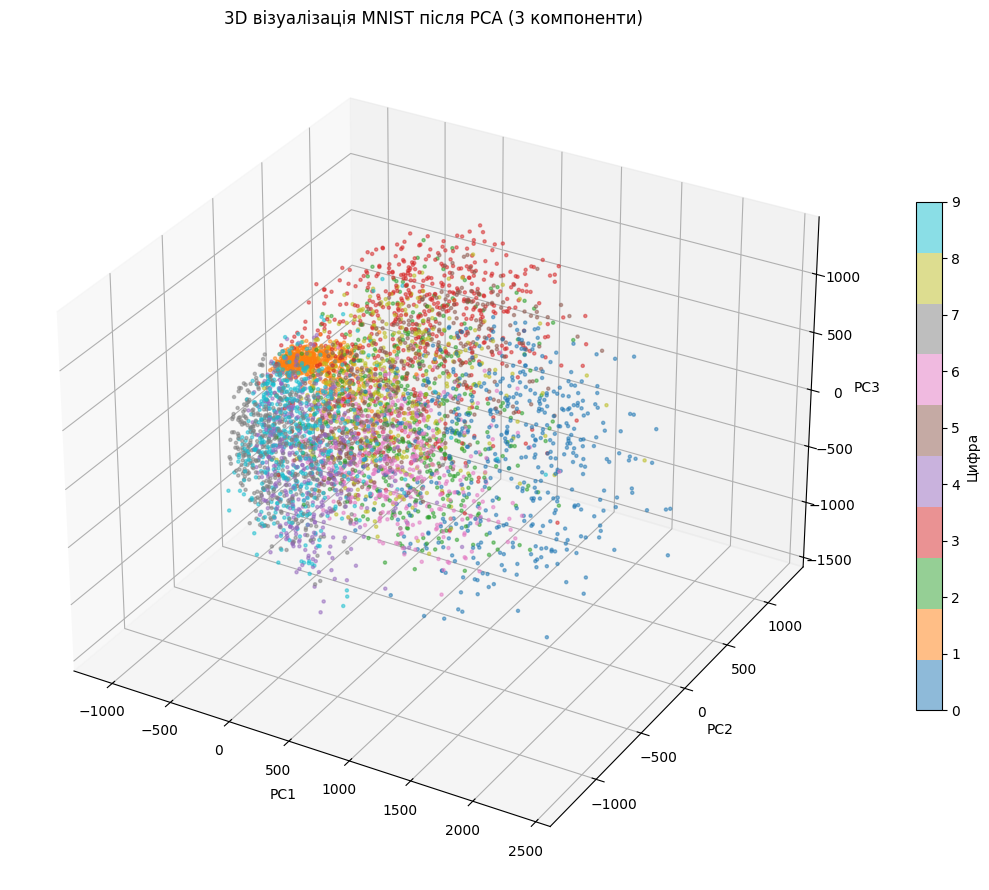


Аналіз кластерів:
- Деякі цифри (наприклад, 0, 1) формують відносно чіткі кластери у 3D просторі.
- Інші цифри (наприклад, 4 і 9, 3 і 5) значно перекриваються,
  що свідчить про їхню візуальну схожість.
- 3 компоненти пояснюють лише ~23% дисперсії, тому повне розділення класів неможливе.
- Для кращого розділення потрібно більше компонент.



In [4]:
# --- 3D візуалізація PCA-проєкції ---

# Створюємо фігуру розміром 12x9 дюймів
fig = plt.figure(figsize=(12, 9))

# Додаємо 3D-підграфік (projection='3d' вмикає тривимірний режим)
ax = fig.add_subplot(111, projection='3d')

# Встановлюємо seed для відтворюваності
np.random.seed(42)

# Обираємо підмножину з 5000 точок для швидшої візуалізації
# (70000 точок на 3D-графіку — занадто повільно та захаращено)
sample_idx = np.random.choice(len(X_pca), size=5000, replace=False)

# Будуємо 3D scatter plot (точковий графік):
#   X_pca[sample_idx, 0] — значення першої головної компоненти (PC1)
#   X_pca[sample_idx, 1] — значення другої головної компоненти (PC2)
#   X_pca[sample_idx, 2] — значення третьої головної компоненти (PC3)
#   c=y_int[sample_idx] — колір кожної точки відповідає мітці цифри (0-9)
#   cmap='tab10' — палітра з 10 різних кольорів для 10 класів
#   alpha=0.5 — напівпрозорість точок (щоб видно перекриття)
#   s=5 — розмір кожної точки
scatter = ax.scatter(
    X_pca[sample_idx, 0],
    X_pca[sample_idx, 1],
    X_pca[sample_idx, 2],
    c=y_int[sample_idx],
    cmap='tab10',
    alpha=0.5,
    s=5
)

# Підписи осей — кожна вісь відповідає одній головній компоненті
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Заголовок графіку
ax.set_title('3D візуалізація MNIST після PCA (3 компоненти)')

# Кольорова шкала збоку — показує відповідність кольору до цифри
plt.colorbar(scatter, label='Цифра', shrink=0.6)

# Автоматичне коригування відступів
plt.tight_layout()

# Відображення графіку
plt.show()

# Текстовий аналіз результатів візуалізації
print("""
Аналіз кластерів:
- Деякі цифри (наприклад, 0, 1) формують відносно чіткі кластери у 3D просторі.
- Інші цифри (наприклад, 4 і 9, 3 і 5) значно перекриваються,
  що свідчить про їхню візуальну схожість.
- 3 компоненти пояснюють лише ~23% дисперсії, тому повне розділення класів неможливе.
- Для кращого розділення потрібно більше компонент.
""")

## 4. Реконструкція зображень після зменшення розмірності

Зворотне перетворення (inverse_transform) дозволяє відновити зображення з PCA-простору назад у 784-вимірний простір. Порівняння оригіналу з реконструкцією показує, скільки інформації втрачається.

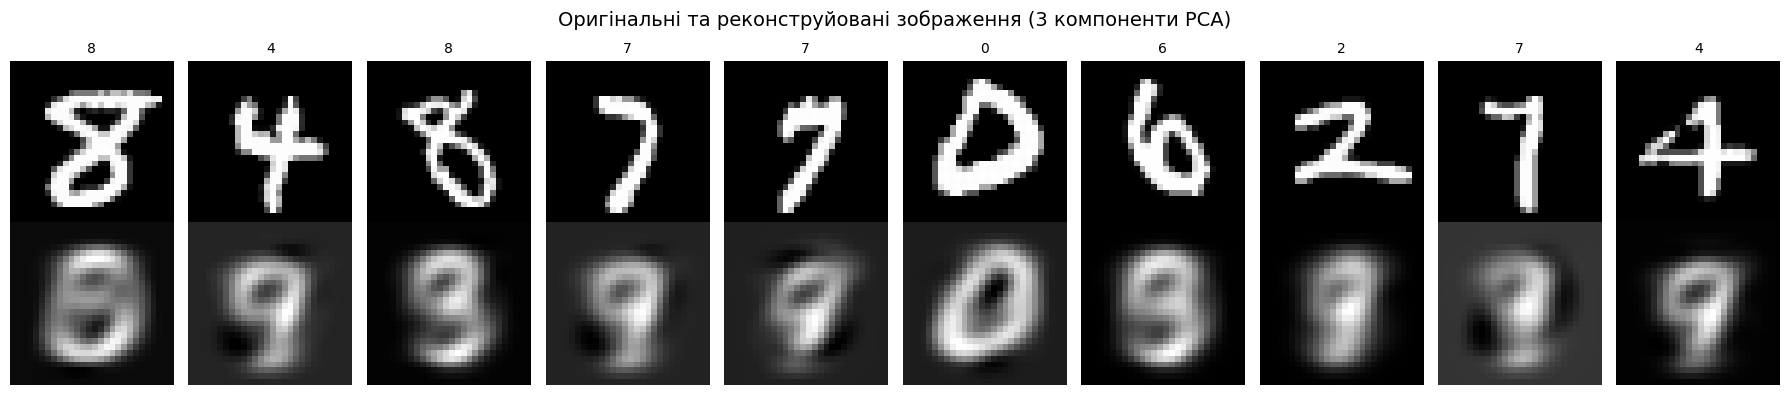

MSE реконструкції з 3 компонентами: 3366.49


In [5]:
# --- Реконструкція зображень з 3 компонент ---

# inverse_transform перетворює дані з PCA-простору (70000, 3) назад у початковий (70000, 784)
# Це "наближена" реконструкція — частина інформації втрачена при стисканні до 3 компонент
X_reconstructed = pca_3.inverse_transform(X_pca)

# Встановлюємо seed для вибору тих самих 10 зображень
np.random.seed(42)

# Обираємо 10 випадкових індексів для порівняння
indices = np.random.choice(len(X), size=10, replace=False)

# Створюємо фігуру з двома рядками по 10 зображень: верхній — оригінал, нижній — реконструкція
fig, axes = plt.subplots(2, 10, figsize=(18, 4))

# Цикл по 10 обраним зображенням
for i, idx in enumerate(indices):
    # Верхній рядок: оригінальне зображення 28x28
    axes[0, i].imshow(X[idx].reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"{y_int[idx]}", fontsize=10)  # Мітка цифри як заголовок
    axes[0, i].axis('off')  # Без осей

    # Нижній рядок: реконструйоване зображення з 3 компонент PCA
    axes[1, i].imshow(X_reconstructed[idx].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')  # Без осей

# Підписи рядків: "Оригінал" та "PCA (k=3)"
axes[0, 0].set_ylabel('Оригінал', fontsize=12, rotation=0, labelpad=60)
axes[1, 0].set_ylabel('PCA (k=3)', fontsize=12, rotation=0, labelpad=60)

# Загальний заголовок фігури
plt.suptitle('Оригінальні та реконструйовані зображення (3 компоненти PCA)', fontsize=14)

# Автоматичне коригування відступів
plt.tight_layout()

# Відображення фігури
plt.show()

# Обчислення MSE (Mean Squared Error) — середньоквадратична помилка реконструкції
# MSE = середнє значення (оригінал - реконструкція)^2 по всіх пікселях всіх зображень
mse_3 = np.mean((X - X_reconstructed) ** 2)
print(f"MSE реконструкції з 3 компонентами: {mse_3:.2f}")

## 5. Аналіз залежності MSE та поясненої дисперсії від кількості компонент

k=  1: MSE= 3948.58, Пояснена дисперсія=  9.75%


k=  2: MSE= 3635.53, Пояснена дисперсія= 16.90%


k=  3: MSE= 3366.49, Пояснена дисперсія= 23.05%


k=  5: MSE= 2916.20, Пояснена дисперсія= 33.34%


k= 10: MSE= 2234.86, Пояснена дисперсія= 48.92%


k= 20: MSE= 1554.40, Пояснена дисперсія= 64.47%


k= 50: MSE=  763.79, Пояснена дисперсія= 82.54%


k=100: MSE=  372.02, Пояснена дисперсія= 91.50%


k=150: MSE=  225.24, Пояснена дисперсія= 94.85%


k=200: MSE=  146.39, Пояснена дисперсія= 96.65%


k=300: MSE=   60.03, Пояснена дисперсія= 98.63%


k=500: MSE=    3.25, Пояснена дисперсія= 99.93%


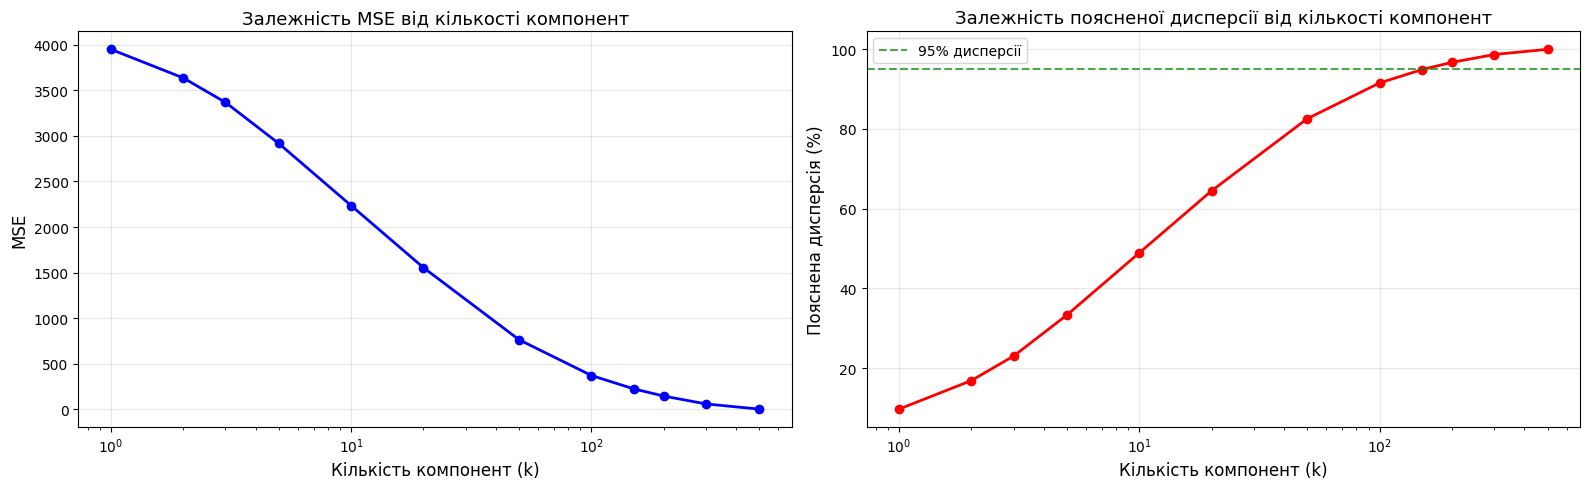

In [6]:
# --- Аналіз залежності MSE та поясненої дисперсії від кількості компонент k ---

# Список значень k (кількість компонент PCA) для дослідження
# Від 1 (мінімальне стиснення) до 500 (майже без втрат, бо 784 — максимум)
k_values = [1, 2, 3, 5, 10, 20, 50, 100, 150, 200, 300, 500]

# Списки для збереження результатів MSE та поясненої дисперсії
mse_values = []
explained_variance_values = []

# Цикл: для кожного значення k виконуємо PCA та обчислюємо метрики
for k in k_values:
    # Створюємо PCA з k компонентами
    pca_k = PCA(n_components=k)

    # Навчаємо PCA та проєктуємо дані у k-вимірний простір
    X_pca_k = pca_k.fit_transform(X)

    # Зворотне перетворення: з k-вимірного простору назад у 784-вимірний
    X_reconstructed_k = pca_k.inverse_transform(X_pca_k)

    # Обчислюємо MSE між оригіналом та реконструкцією
    # Чим менше MSE — тим краща реконструкція
    mse_k = np.mean((X - X_reconstructed_k) ** 2)
    mse_values.append(mse_k)

    # Сумарна пояснена дисперсія для k компонент
    # Показує, яку частку загальної варіативності даних пояснюють k компонент
    total_var = np.sum(pca_k.explained_variance_ratio_)
    explained_variance_values.append(total_var)

    # Вивід результатів для кожного k
    print(f"k={k:>3d}: MSE={mse_k:>8.2f}, Пояснена дисперсія={total_var*100:>6.2f}%")

# --- Побудова двох графіків поряд ---

# Створюємо фігуру з двома підграфіками: лівий — MSE(k), правий — дисперсія(k)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# --- Лівий графік: MSE(k) ---
# 'bo-' — сині точки з'єднані лініями
ax1.plot(k_values, mse_values, 'bo-', linewidth=2, markersize=6)
ax1.set_xlabel('Кількість компонент (k)', fontsize=12)  # Підпис осі X
ax1.set_ylabel('MSE', fontsize=12)  # Підпис осі Y
ax1.set_title('Залежність MSE від кількості компонент', fontsize=13)  # Заголовок
ax1.grid(True, alpha=0.3)  # Сітка з прозорістю 0.3
ax1.set_xscale('log')  # Логарифмічна шкала по X (бо k змінюється від 1 до 500)

# --- Правий графік: Пояснена дисперсія(k) ---
# 'ro-' — червоні точки з'єднані лініями
ax2.plot(k_values, [v * 100 for v in explained_variance_values], 'ro-', linewidth=2, markersize=6)
ax2.set_xlabel('Кількість компонент (k)', fontsize=12)  # Підпис осі X
ax2.set_ylabel('Пояснена дисперсія (%)', fontsize=12)  # Підпис осі Y
ax2.set_title('Залежність поясненої дисперсії від кількості компонент', fontsize=13)  # Заголовок
ax2.grid(True, alpha=0.3)  # Сітка
ax2.set_xscale('log')  # Логарифмічна шкала по X

# Горизонтальна пунктирна лінія на рівні 95% — порогове значення "достатньої" дисперсії
ax2.axhline(y=95, color='green', linestyle='--', alpha=0.7, label='95% дисперсії')

# Легенда з поясненням пунктирної лінії
ax2.legend()

# Автоматичне коригування відступів
plt.tight_layout()

# Відображення графіків
plt.show()

## Висновки

1. **PCA** успішно зменшує розмірність даних із 784 до довільної кількості компонент.
2. З **3 компонентами** (~23% дисперсії) форми цифр ще розпізнаються, але зображення розмиті.
3. **3D візуалізація** показує часткове розділення класів — цифри 0 та 1 формують окремі кластери, тоді як 4/9, 3/5 перекриваються через візуальну схожість.
4. **MSE** швидко зменшується для перших ~50 компонент, далі покращення сповільнюється.
5. Для досягнення **95% поясненої дисперсії** потрібно приблизно 150–200 компонент, що значно менше за початкові 784 ознаки.